In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Processing Data

In [2]:
collected_img = r'.\collectedimages' 
classes = os.listdir(collected_img)
num_classes = len(classes)

print(f'Classes : {classes}\nNum class : {num_classes}')

Classes : ['botolkaca', 'botolplastik', 'kaleng', 'kardus', 'karet', 'kertas', 'plastik', 'sedotan']
Num class : 8


In [3]:
datagen = ImageDataGenerator(
                rotation_range=5,
                width_shift_range=0.2,
                height_shift_range=0.2,
                rescale=1/255.,
                # shear_range=0.2,
                # zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest',
                validation_split=0.2
                )

batch_size = 32

train_gene = datagen.flow_from_directory(
        collected_img,  
        target_size=(224, 224),  
        batch_size=batch_size,
        subset='training',
        # shuffle=False,
        classes=classes)

valid_gene = datagen.flow_from_directory(
        collected_img,
        target_size=(224, 224), 
        batch_size=batch_size, 
        subset='validation',
        # shuffle=False,
        classes=classes)

Found 2938 images belonging to 8 classes.
Found 729 images belonging to 8 classes.


## Model Creation

In [4]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [5]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# for layer in base_model.layers:
#     layer.trainable = False
trainable_break = 40
for layer in base_model.layers[:trainable_break]:
    # print(layer.name)
    layer.trainable=False
    
for layer in base_model.layers[trainable_break:]:
    layer.trainable=True

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation='relu')(x)
x = Dropout(.3)(x)

preds = Dense(num_classes, activation='sigmoid')(x)

model=Model(inputs=base_model.input, outputs=preds)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [7]:
# from tensorflow.keras import backend as K

# def Recall(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

# def Precision(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision

# def F1Score(y_true, y_pred):
#     precision = Precision(y_true, y_pred)
#     recall = Recall(y_true, y_pred)
#     return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])

In [9]:
history = model.fit(train_gene, 
                    epochs = 5, 
                    steps_per_epoch = train_gene.samples // batch_size,
                    validation_data = valid_gene, 
                    validation_steps = valid_gene.samples // batch_size)

Epoch 1/5
91/91 [==============================] - 79s 738ms/step - loss: 0.5572 - accuracy: 0.8348 - val_loss: 3.3858 - val_accuracy: 0.4815
Epoch 2/5
91/91 [==============================] - 67s 738ms/step - loss: 0.2347 - accuracy: 0.9312 - val_loss: 6.3378 - val_accuracy: 0.3423
Epoch 3/5
91/91 [==============================] - 57s 627ms/step - loss: 0.1294 - accuracy: 0.9597 - val_loss: 3.5363 - val_accuracy: 0.5668
Epoch 4/5
91/91 [==============================] - 70s 767ms/step - loss: 0.1000 - accuracy: 0.9680 - val_loss: 3.8588 - val_accuracy: 0.5384
Epoch 5/5
91/91 [==============================] - 54s 591ms/step - loss: 0.1306 - accuracy: 0.9625 - val_loss: 2.1244 - val_accuracy: 0.6222


In [10]:
import matplotlib.pyplot as plt

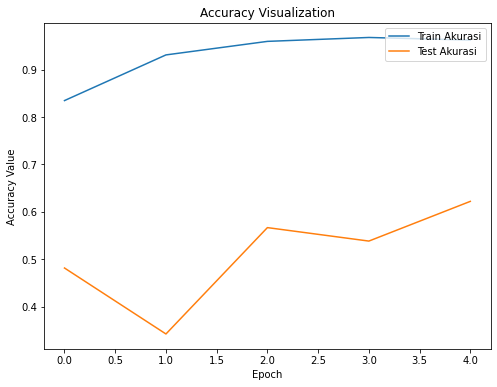

In [11]:
#@title Visualisasi Akurasi
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label="Train Akurasi")
plt.plot(history.history['val_accuracy'], label="Test Akurasi")
plt.title('Accuracy Visualization')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

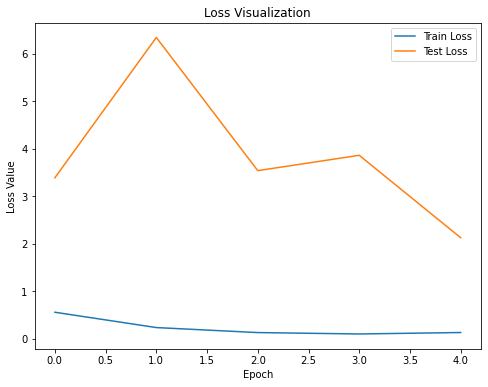

In [12]:
#@title Visualisasi Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Test Loss")
plt.title('Loss Visualization')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

### Saving model

In [13]:
model.save('tensorflow_model_array/model')

INFO:tensorflow:Assets written to: tensorflow_model_array/model\assets


In [14]:
model.save('tensorflow_model_array/model.h5')

## SAVE to BASE64

In [17]:
def load_model():
    model_path = r'./tensorflow_model_array/model.h5'

    model = tf.keras.models.load_model(model_path)

    # model.summary()

    def decode_jpeg(x):
        x = tf.io.decode_base64(x)
        x =tf.image.resize(tf.image.decode_jpeg(x, channels=3), [224, 224])
        x = tf.reshape(x, [224, 224, 3])
        return x

    @tf.function()
    def serve_predict(input):
        
        model_base64_input = tf.map_fn(lambda x: decode_jpeg(x), input, fn_output_signature=tf.float32)
        pixels = model_base64_input

        input = {
            'input_1': pixels,
        }

        prediction = model(input)
        return prediction

    serve_predict = serve_predict.get_concrete_function(input=tf.TensorSpec([None, ], dtype=tf.string))

    tf.saved_model.save(
        model,
        'tensorflow_model_b64',
        signatures=serve_predict
    )
    pass

In [18]:
load_model()

INFO:tensorflow:Assets written to: tensorflow_model_b64\assets


## Test base64

In [ ]:
# from tensorflow.keras.models import load_model
# import base64

In [ ]:
# model_loaded = load_model(r'.\myModels\001')

# IMG_PATH_RANDOM = r'.\collectedimages\karet\20220519_183413.jpg'

# with open(IMG_PATH_RANDOM, "rb") as image_file:
#     encoded_string = base64.b64encode(image_file.read())

In [ ]:
# np.array([encoded_string]).shape

In [ ]:
# model_loaded.predict(encoded_string)